In [1]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
DATA_ROOT = "data"  # change to your dataset root
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR = os.path.join(DATA_ROOT, "val")
CACHE_TO_NPY = False  # set True to create .npy cache copies for faster I/O
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [3]:
try:
    import rasterio
    from rasterio.enums import Resampling

    def read_tif(path):
        with rasterio.open(path) as src:
            arr = src.read().astype(np.float32)  # shape (bands, H, W)
        return arr

    print("Using rasterio for TIFF reading")
except Exception as e:
    print("rasterio not available (or failed). Falling back to tifffile. Error:", e)
    import tifffile

    def read_tif(path):
        arr = tifffile.imread(path).astype(np.float32)
        # tifffile often returns (H,W,bands) or (bands,H,W)
        if arr.ndim == 3 and arr.shape[-1] == 12 and arr.shape[0] != 12:
            arr = np.transpose(arr, (2, 0, 1))
        elif arr.ndim == 2:
            arr = arr[np.newaxis, ...]
        elif arr.ndim == 3 and arr.shape[0] == 12:
            pass
        else:
            # try to be permissive
            arr = np.transpose(arr, (2, 0, 1)) if arr.shape[-1] <= 64 else arr
        return arr

Using rasterio for TIFF reading


In [4]:
def read_mask(path):
    # use rasterio if available, else tifffile
    try:
        if "rasterio" in globals():
            with rasterio.open(path) as src:
                m = src.read(1).astype(np.uint8)
        else:
            m = tifffile.imread(path).astype(np.uint8)
    except Exception:
        # fallback to imageio
        import imageio

        m = imageio.imread(path).astype(np.uint8)
    # ensure binary 0/1
    m = (m > 0).astype(np.uint8)
    return m

In [5]:
import os, glob

def find_pairs(data_dir, img_dir="images", mask_dir="labels", img_ext=".tif", mask_ext=".png"):
    """
    Finds image–mask pairs when images are in images/ and masks in labels/.
    Matches by numeric basename (e.g., 0.tif <-> 0.png).
    """
    img_paths = glob.glob(os.path.join(data_dir, img_dir, f"*{img_ext}"))
    x, y = [], []

    print(f"Found {len(img_paths)} image files in {os.path.join(data_dir, img_dir)}")

    for img_path in img_paths:
        base = os.path.splitext(os.path.basename(img_path))[0]  # e.g. "0"
        mask_path = os.path.join(data_dir, mask_dir, base + mask_ext)
        if os.path.exists(mask_path):
            x.append(img_path)
            y.append(mask_path)
            print(f"✅ Pair: {img_path} <-> {mask_path}")
        else:
            print(f"⚠️ No mask found for {img_path}")

    print(f"Total pairs in {data_dir}: {len(x)}")
    return x, y


# usage
TRAIN_DIR = r"data/train"
VAL_DIR   = r"data/val"

x_train, y_train = find_pairs(TRAIN_DIR)
x_val, y_val = find_pairs(VAL_DIR)


Found 244 image files in data/train\images
✅ Pair: data/train\images\0.tif <-> data/train\labels\0.png
✅ Pair: data/train\images\1.tif <-> data/train\labels\1.png
✅ Pair: data/train\images\10.tif <-> data/train\labels\10.png
✅ Pair: data/train\images\101.tif <-> data/train\labels\101.png
✅ Pair: data/train\images\102.tif <-> data/train\labels\102.png
✅ Pair: data/train\images\103.tif <-> data/train\labels\103.png
✅ Pair: data/train\images\104.tif <-> data/train\labels\104.png
✅ Pair: data/train\images\105.tif <-> data/train\labels\105.png
✅ Pair: data/train\images\106.tif <-> data/train\labels\106.png
✅ Pair: data/train\images\107.tif <-> data/train\labels\107.png
✅ Pair: data/train\images\108.tif <-> data/train\labels\108.png
✅ Pair: data/train\images\110.tif <-> data/train\labels\110.png
✅ Pair: data/train\images\113.tif <-> data/train\labels\113.png
✅ Pair: data/train\images\114.tif <-> data/train\labels\114.png
✅ Pair: data/train\images\115.tif <-> data/train\labels\115.png
✅ Pair:

In [6]:
print(f"Found {len(x_train)} training pairs and {len(x_val)} val pairs (guessed).")


Found 244 training pairs and 62 val pairs (guessed).


In [7]:
if CACHE_TO_NPY:
    out_train = os.path.join(TRAIN_DIR, 'cache')
    out_val = os.path.join(VAL_DIR, 'cache')
    os.makedirs(out_train, exist_ok=True)
    os.makedirs(out_val, exist_ok=True)
    print('Caching train...')
    for i,(x,y) in enumerate(zip(x_train,y_train)):
        arr = read_tif(x) # (bands,H,W)
        np.save(os.path.join(out_train, f"sample_{i:04d}_X.npy"), arr)
        mask = read_mask(y)
        np.save(os.path.join(out_train, f"sample_{i:04d}_Y.npy"), mask)
    print('Caching val...')
    for i,(x,y) in enumerate(zip(x_val,y_val)):
        arr = read_tif(x)
        np.save(os.path.join(out_val, f"sample_{i:04d}_X.npy"), arr)
        mask = read_mask(y)
        np.save(os.path.join(out_val, f"sample_{i:04d}_Y.npy"), mask)
    print('Cache finished')

In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from PIL import Image

def display_image_and_mask(img_path, mask_path, channels=[3,2,1]):
    with rasterio.open(img_path) as src:
        # Read specific bands (note: rasterio bands are 1-indexed)
        img = np.stack([src.read(c) for c in channels], axis=-1)

        # Normalize for display
        img = img.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min())

    # Read mask (assuming it's a single-channel label image)
    with rasterio.open(mask_path) as src:
        mask = src.read(1)

    # Show image + mask
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img)
    axs[0].set_title("Satellite Image (channels 3-2-1)")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Mask")
    axs[1].axis("off")

    plt.show()


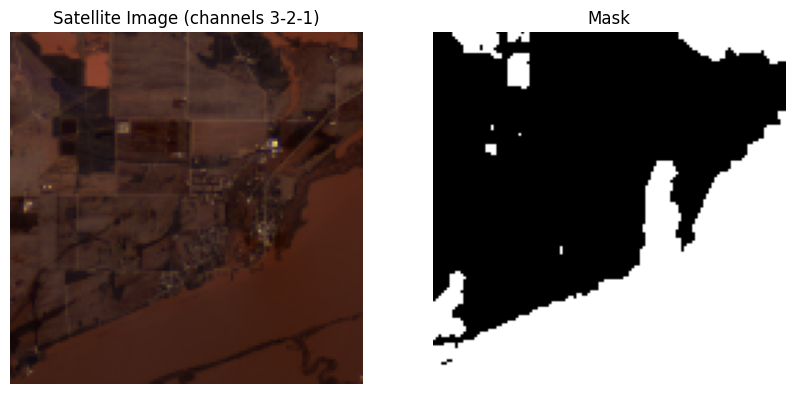

In [17]:

train_img_dir = r"data/train/images"
train_mask_dir = r"data/train/labels"

# Get image and mask filenames and sort them to ensure matching
train_img_files = sorted(os.listdir(train_img_dir))
train_mask_files = sorted(os.listdir(train_mask_dir))

# Check that the number of images matches the number of masks
if len(train_img_files) != len(train_mask_files):
    print("Error: The number of images and masks do not match!")
else:
    # Display only the first 5 image-mask pairs
    for img_file, mask_file in zip(train_img_files[20:21], train_mask_files[20:21]):
        # Construct the full file paths
        img_path = os.path.join(train_img_dir, img_file)
        mask_path = os.path.join(train_mask_dir, mask_file)
        # Display the image and mask together
        display_image_and_mask(img_path, mask_path)

In [18]:
from albumentations import Compose, HorizontalFlip, VerticalFlip, RandomRotate90, ElasticTransform, GridDistortion, ShiftScaleRotate, RandomBrightnessContrast

def default_augmentations():
    return Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    ElasticTransform(p=0.2),
    GridDistortion(p=0.2),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    RandomBrightnessContrast(p=0.3),
    ])

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [19]:
class MultiSpectralTifDataset(Dataset):
    def __init__(self, x_paths, y_paths, transform=None, norm_mode="per_sample", cache=False):
        assert len(x_paths) == len(y_paths)
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.transform = transform
        self.norm_mode = norm_mode
        self.cache = cache


    def __len__(self):
        return len(self.x_paths)


    def _normalize_per_sample(self, x):
        mean = x.mean(axis=(1,2), keepdims=True)
        std = x.std(axis=(1,2), keepdims=True)
        std[std==0] = 1.0
        return (x - mean) / std


    def _minmax_per_sample(self, x):
        mn = x.min(axis=(1,2), keepdims=True)
        mx = x.max(axis=(1,2), keepdims=True)
        rng = (mx - mn)
        rng[rng==0] = 1.0
        return (x - mn) / rng


    def __getitem__(self, idx):
        x_path = self.x_paths[idx]
        y_path = self.y_paths[idx]


        if x_path.lower().endswith('.npy'):
            x = np.load(x_path).astype(np.float32)
        else:
            x = read_tif(x_path).astype(np.float32)
        # ensure shape (bands,H,W)
        if x.ndim == 3 and x.shape[-1] == 12 and x.shape[0] != 12:
            x = np.transpose(x, (2,0,1))
        if x.ndim == 2:
            x = x[np.newaxis, ...]


        y = read_mask(y_path).astype(np.uint8)


        # Normalization
        if self.norm_mode == "per_sample":
            x = self._normalize_per_sample(x)
        elif self.norm_mode == "minmax":
            x = self._minmax_per_sample(x)
        elif self.norm_mode == "none":
            pass


        # Albumentations expects HWC
        if self.transform is not None:
            x_hwc = np.transpose(x, (1,2,0))
            augmented = self.transform(image=x_hwc, mask=y)
            x_hwc = augmented['image']
            y = augmented['mask']
            x = np.transpose(x_hwc, (2,0,1))


        x_t = torch.from_numpy(x).float()
        y_t = torch.from_numpy(y).long()
        return x_t, y_t

In [20]:
def show_band_grid(x_numpy, bands=None, figsize=(10,8), cmap='gray'):
    assert x_numpy.shape[0] >= 1
    n = x_numpy.shape[0]
    ncols = 4
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=figsize)
    
    for i in range(n):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(x_numpy[i], cmap=cmap)
        title = f"B{i}" if bands is None else bands[i]
        plt.title(title)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

In [21]:
from PIL import Image
from tensorflow.keras import layers, Model, Input

def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [31]:
from tensorflow.keras.utils import Sequence
import numpy as np
import tifffile
import cv2
import os
from skimage.transform import resize


class TiffDataGenerator(Sequence):
    def __init__(self, img_dir, mask_dir, img_size=(128,128), batch_size=16):
        self.img_files = sorted(os.listdir(img_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.img_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.img_files[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.mask_files[idx*self.batch_size:(idx+1)*self.batch_size]

        imgs, masks = [], []
        for img_file, mask_file in zip(batch_x, batch_y):
            # --- Load .tif image ---
            img = tifffile.imread(os.path.join(self.img_dir, img_file))
            img_resized = resize(img, (*self.img_size, img.shape[-1]), preserve_range=True, anti_aliasing=True)
            img_resized = img_resized.astype(np.float32) / 255.0

            # --- Load mask (already 0/1 values) ---
            mask = cv2.imread(os.path.join(self.mask_dir, mask_file), cv2.IMREAD_UNCHANGED)
            mask_resized = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
            mask_resized = mask_resized.astype(np.float32)
            mask_resized = np.expand_dims(mask_resized, axis=-1)

            imgs.append(img_resized)
            masks.append(mask_resized)

        return np.array(imgs), np.array(masks)


In [30]:
import cv2, os
mask_path = os.path.join("data/train/labels", os.listdir("data/train/labels")[0])
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
print("Mask shape:", mask.shape)
print("Unique values:", np.unique(mask))


Mask shape: (128, 128)
Unique values: [0 1]


In [33]:
train_generator = TiffDataGenerator("data/train/images", "data/train/labels",
                                    img_size=(128,128), batch_size=16)

val_generator   = TiffDataGenerator("data/val/images", "data/val/labels",
                                    img_size=(128,128), batch_size=16)


Image shape: (128, 128, 12)
Mask unique values: [0. 1.]


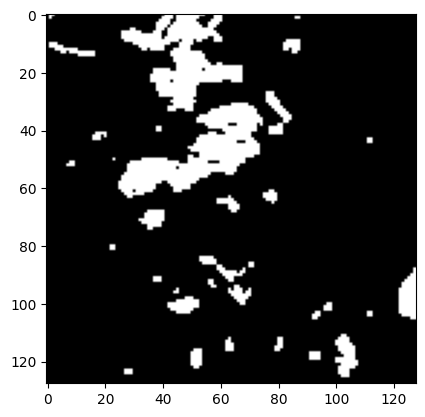

In [34]:
imgs, masks = train_generator[0]
print("Image shape:", imgs[0].shape)   # (128,128,12)
print("Mask unique values:", np.unique(masks[0]))  # should be [0. 1.]
plt.imshow(masks[0].squeeze(), cmap="gray")
plt.show()


In [36]:
model = unet_model(input_size=(128, 128, 12))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])  # you should add IoU or Dice

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

c:\Users\motaw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8287 - loss: 0.4464 - val_accuracy: 0.8822 - val_loss: 0.3470
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8880 - loss: 0.2956 - val_accuracy: 0.8836 - val_loss: 0.3045
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8945 - loss: 0.2878 - val_accuracy: 0.8972 - val_loss: 0.2640
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9055 - loss: 0.2580 - val_accuracy: 0.9054 - val_loss: 0.2489
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9078 - loss: 0.2454 - val_accuracy: 0.9072 - val_loss: 0.2531
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9085 - loss: 0.2418 - val_accuracy: 0.8998 - val_loss: 0.2659
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8970 - loss: 0.2746 - val_accuracy: 0.9073 - val_loss: 0.2670
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9079 - loss: 0.2577 - val_accuracy: 0.9072 - val_loss:

In [37]:
loss, accuracy = model.evaluate(val_generator, steps=50)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9025 - loss: 0.2492  
Validation Loss: 0.24918243288993835
Validation Accuracy: 0.9025219082832336


c:\Users\motaw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [38]:
def overlay_predictions(model, generator, alpha=0.5, batch_idx=0, channels=[3,2,1]):
    # Get one batch
    images, masks = generator[batch_idx]  

    # Run prediction
    predictions = model.predict(images)

    for i in range(len(images)):
        plt.figure(figsize=(12, 6))

        # Reorder channels for visualization
        img = images[i][..., channels]  

        # Normalize for display (to 0-1 range)
        img = img.astype(float)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        # Show input
        plt.subplot(1, 2, 1)
        plt.title("Input Image (bands 3-2-1)")
        plt.imshow(img)
        plt.axis('off')

        # Show overlay with predictions
        plt.subplot(1, 2, 2)
        plt.title("Prediction Overlay")
        plt.imshow(img)
        plt.imshow(predictions[i].squeeze(), cmap='jet', alpha=alpha)
        plt.axis('off')

        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


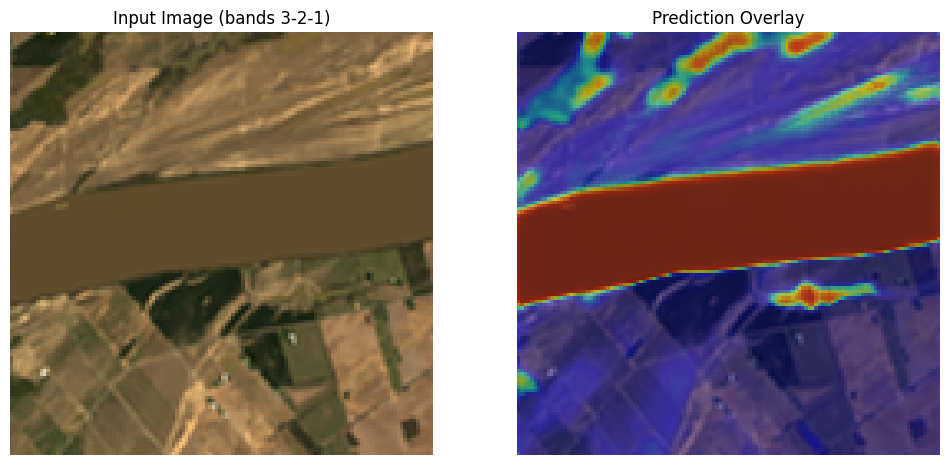

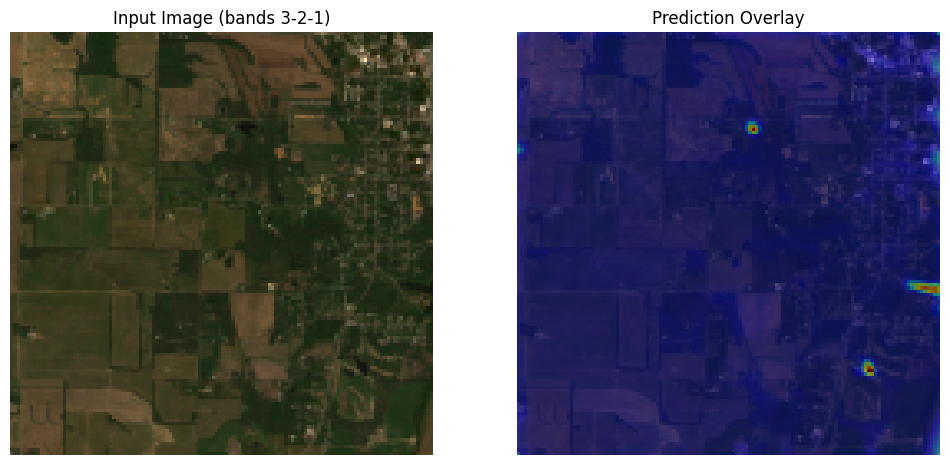

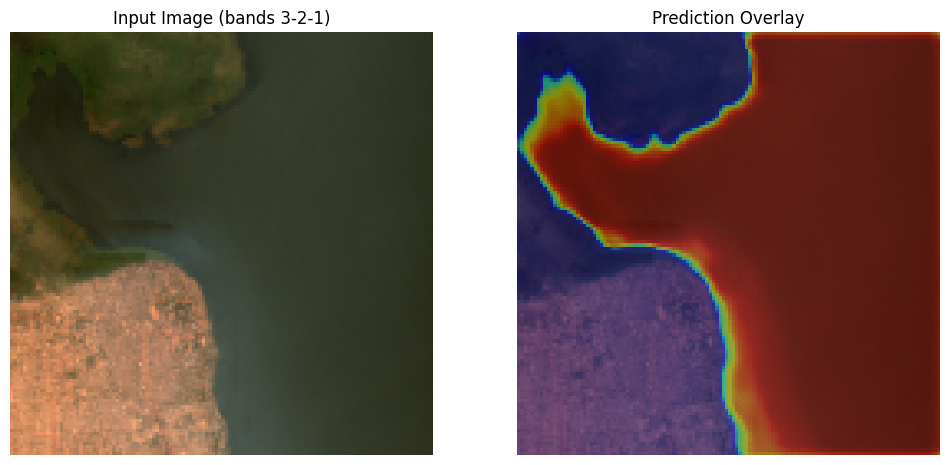

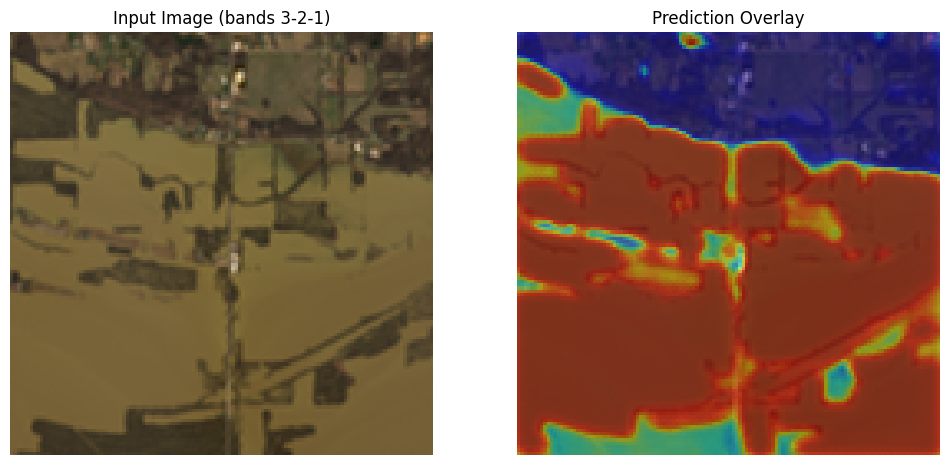

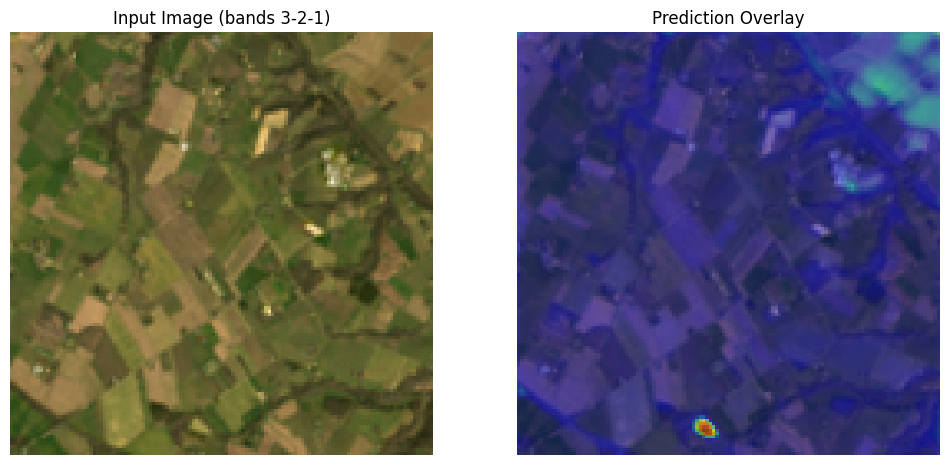

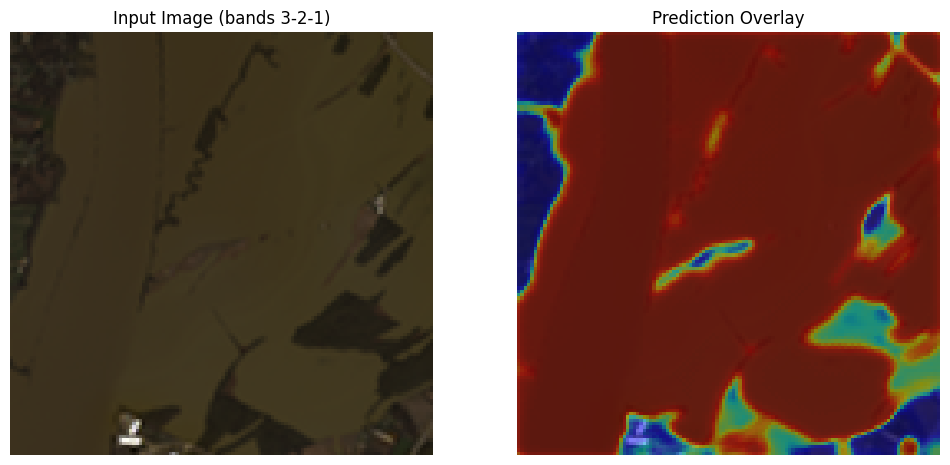

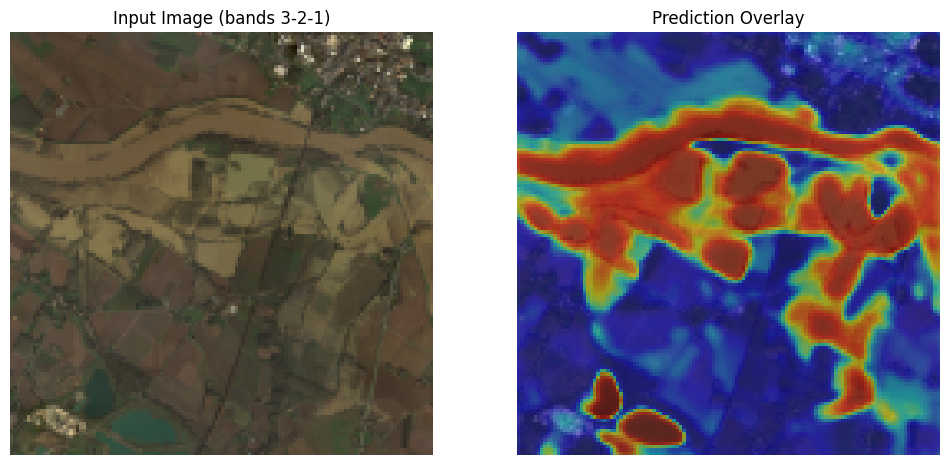

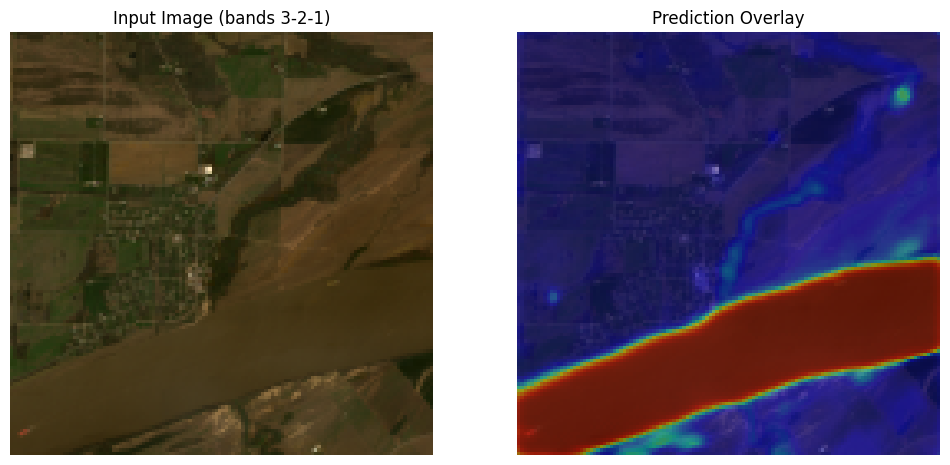

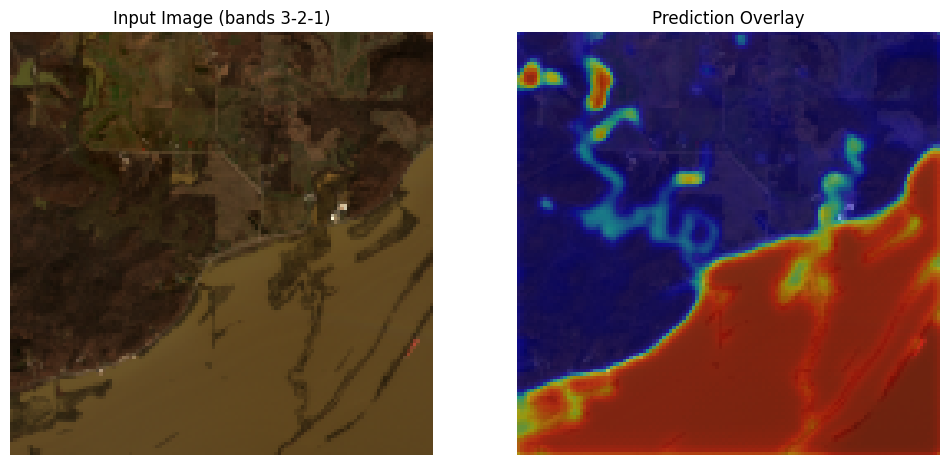

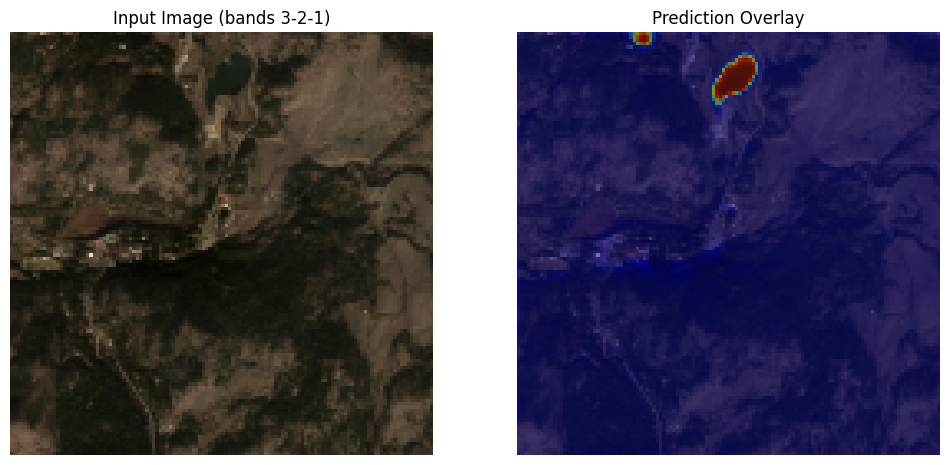

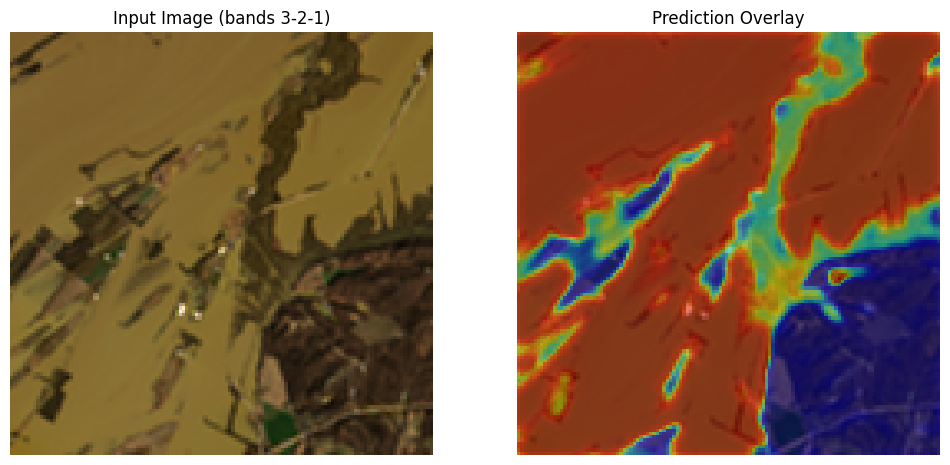

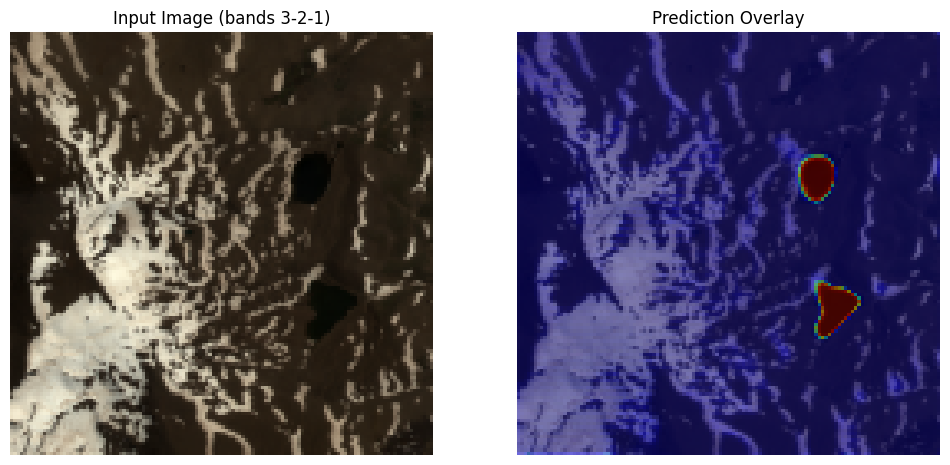

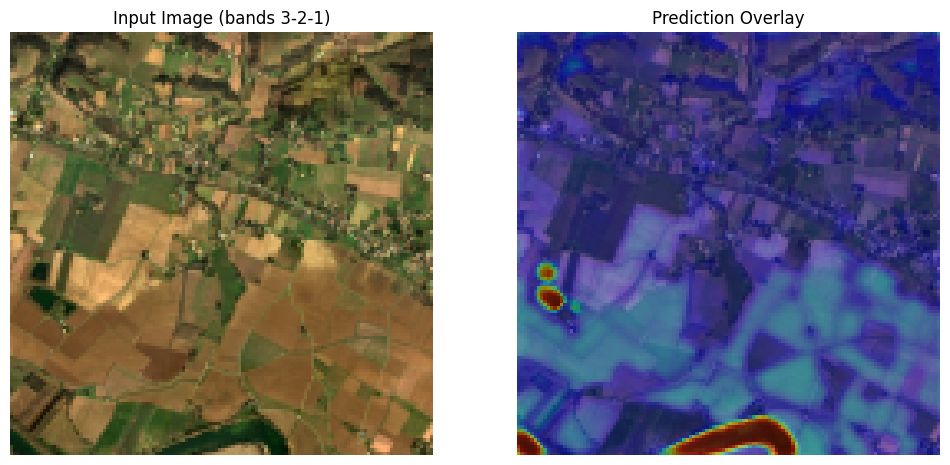

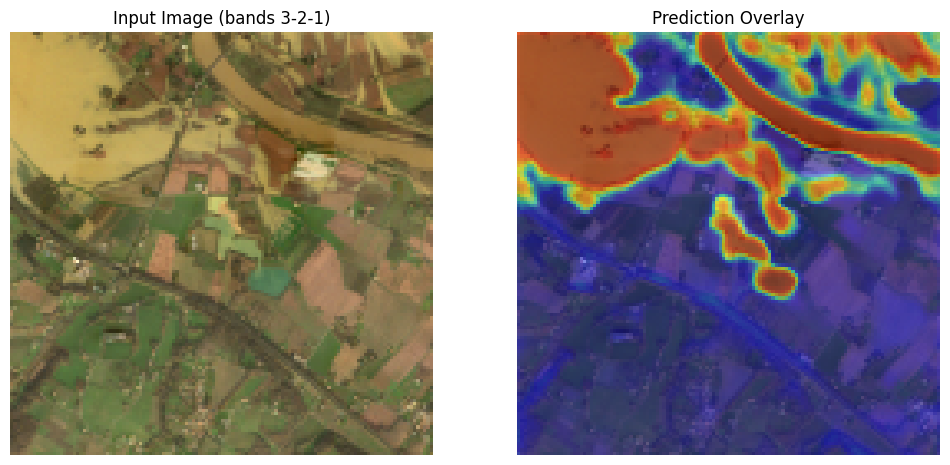

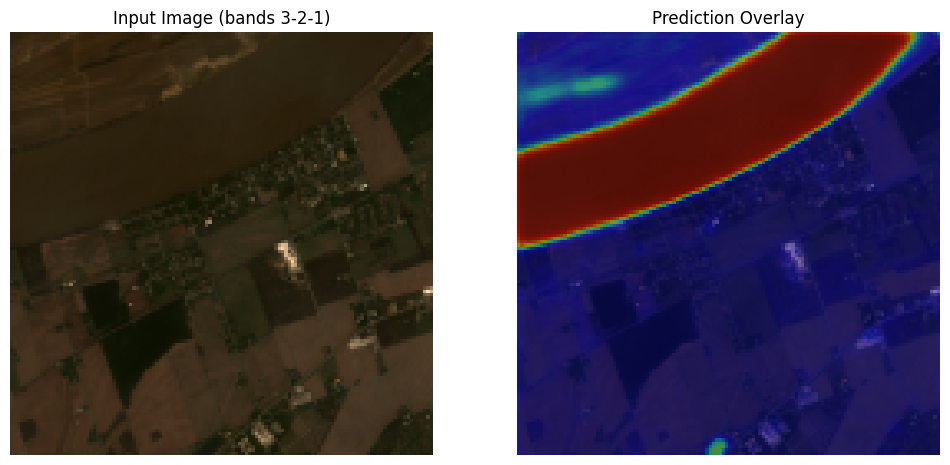

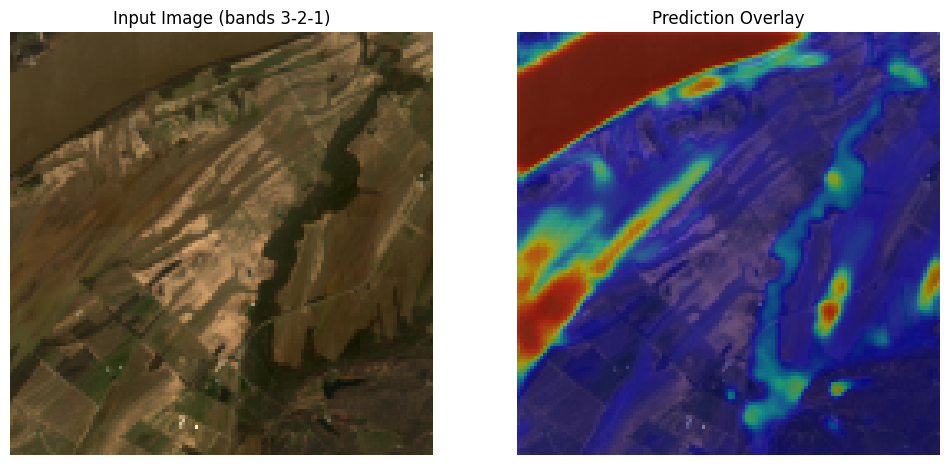

In [39]:
overlay_predictions(model, val_generator)


In [40]:
model.save("unet_satellite_model.h5")
model.save("unet_satellite_model.keras")